In [1]:
from sippy import *
import numpy as np
import pandas as pd
import plots
from scipy.signal import detrend, butter, filtfilt

In [2]:
#load spteptest data from a TSV file
file = r'..\data\hp.csv'
step_test_data = pd.read_csv(file,header=[0, 1,2],index_col=[0], parse_dates=[0])
step_test_data.head()

Time,GAS.PV,HPCPOWER.PV,KOPC_OP,KOPC_SP,PIC100X_OP,PIC100X_SP,TIC100_OP,TIC100_SP,WELL1.OP,WELL2.OP,WELL3.OP
,b VEC VEC,HP Comp. Power VEC VEC,KOPC Output VEC,KOPC Set Point VEC,PIC100X Output VEC,PIC100X Set Point VEC,TIC100 Output VEC,TIC100 Set Point VEC,Well 1 Valve % VEC,Well 2 Valve % VEC,Well 3 Valve % VEC
,x,kW,kPa,kPa,kPa,kPa,C,C,%,%,%
2016-06-21 20:31:00,151.078,3002.80,92.4470,2670.4,61.7873,2900.0,20.0780,22.0889,81.0083,76.8083,75.3363
2016-06-21 20:32:00,152.016,3013.55,92.4290,2670.4,63.3735,2850.0,20.0773,22.0889,81.0083,76.8083,75.3363
2016-06-21 20:33:00,152.174,3015.59,92.5516,2670.4,65.0172,2847.5,20.1263,22.0889,81.0083,76.8083,75.3363
2016-06-21 20:34:00,152.286,3013.44,92.7653,2670.4,66.0057,2847.5,20.1540,22.0889,81.0083,76.8083,75.3363
2016-06-21 20:35:00,151.960,3011.35,92.9511,2670.4,67.2628,2847.5,20.1795,22.0889,81.0083,76.8083,75.3363


In [3]:
#slice data for model identification case
start = '2016-06-21 20:31:00'
end = '2016-07-19 18:00:00'
step_test = step_test_data.loc[start:end]
Time = step_test.index

#Drop mutilevel index
step_test.columns = [col[0] for col in step_test.columns]
step_test.head()

,GAS.PV,HPCPOWER.PV,KOPC_OP,KOPC_SP,PIC100X_OP,PIC100X_SP,TIC100_OP,TIC100_SP,WELL1.OP,WELL2.OP,WELL3.OP
2016-06-21 20:31:00,151.078,3002.80,92.4470,2670.4,61.7873,2900.0,20.0780,22.0889,81.0083,76.8083,75.3363
2016-06-21 20:32:00,152.016,3013.55,92.4290,2670.4,63.3735,2850.0,20.0773,22.0889,81.0083,76.8083,75.3363
2016-06-21 20:33:00,152.174,3015.59,92.5516,2670.4,65.0172,2847.5,20.1263,22.0889,81.0083,76.8083,75.3363
2016-06-21 20:34:00,152.286,3013.44,92.7653,2670.4,66.0057,2847.5,20.1540,22.0889,81.0083,76.8083,75.3363
2016-06-21 20:35:00,151.960,3011.35,92.9511,2670.4,67.2628,2847.5,20.1795,22.0889,81.0083,76.8083,75.3363


In [4]:
#select Inputs and Outputs for the model identification case
inputs = ['KOPC_SP', 'PIC100X_SP', 'TIC100_SP', 'WELL1.OP', 'WELL2.OP', 'WELL3.OP']
outputs = ['GAS.PV', 'HPCPOWER.PV', 'KOPC_OP', 'PIC100X_OP','TIC100_OP']

In [5]:
#Convert dataframe to numpy arry.
u = step_test[inputs].to_numpy().T
y = step_test[outputs].to_numpy().T
print('Output shape:', y.shape)
print('Input shape:',u.shape)

Output shape: (5, 40170)
Input shape: (6, 40170)


In [6]:
#specify model identification parameters, reffer the documentation for detais.
method='CVA'
IC = 'AIC' # None, AIC, AICc, BIC
TH = 30 # The length of time horizon used for regression
fix_ordr = 4 # Used if and only if IC = 'None'
max_order = 25 # Used if IC = AIC, AICc or BIC
req_D = False
force_A_stable = False

In [7]:
# Detrending anf filtering signals
tss = 90 #Time to steady state
u_detend = detrend(u, type='linear')
y_detend = detrend(y, type='linear')

b, a = butter(10, 2/3/tss, 'highpass', analog=True) #filter any frequency  slower than 3*tss
u_filt = filtfilt(b, a, u_detend, method="gust")
y_filt = filtfilt(b, a, y_detend, method="gust")

In [8]:
# Fit model
sys_id = system_identification(
    y_filt, 
    u_filt, 
    method,
    SS_fixed_order=fix_ordr,
    SS_max_order=max_order,
    IC=IC,
    SS_f=TH,
    SS_p=TH,
    SS_D_required=req_D,
    SS_A_stability=force_A_stable
    )

#print model order
# print('Model order:', sys_id.n)

#save model parameters A, B, C,D and X0 as npz file
model = 'feac2.npz'
np.savez(model, A=sys_id.A, B=sys_id.B, C=sys_id.C, D=sys_id.D, K=sys_id.K, X0=sys_id.x0)

The suggested order is: n= 10


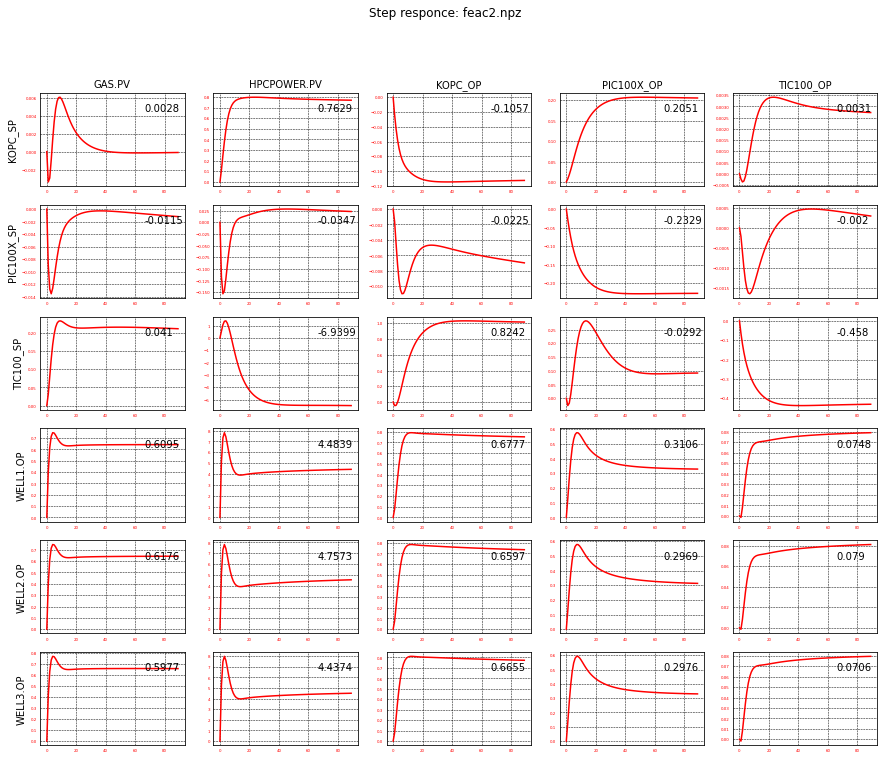

In [9]:
plots.plot_model(model, inputs, outputs, tss=tss)

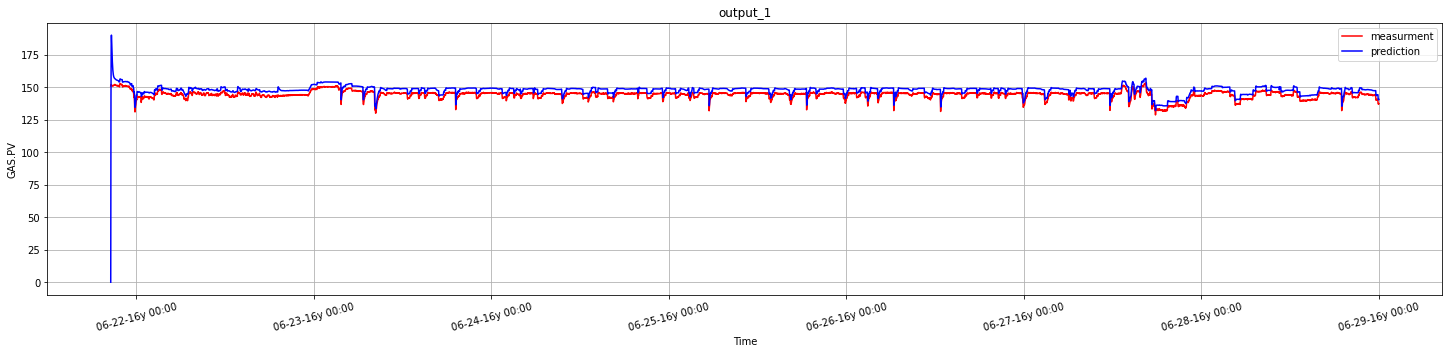

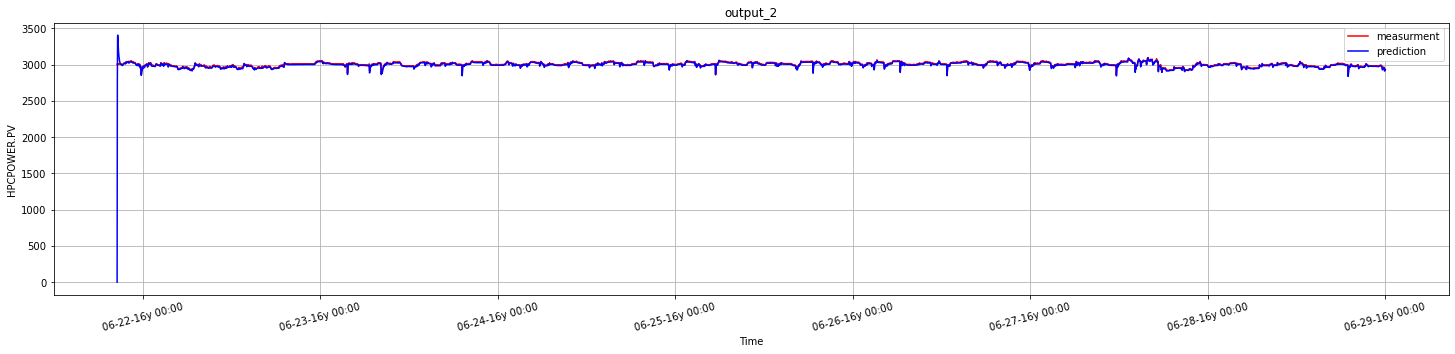

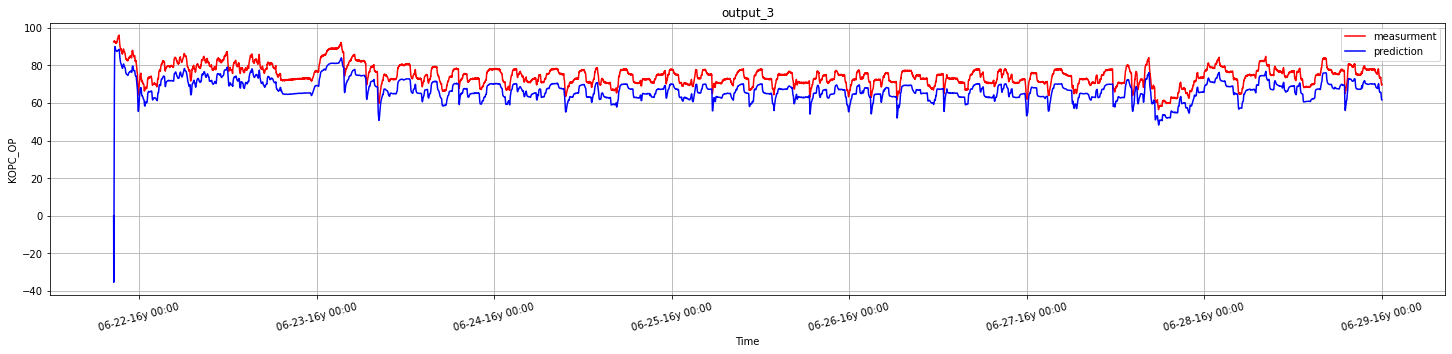

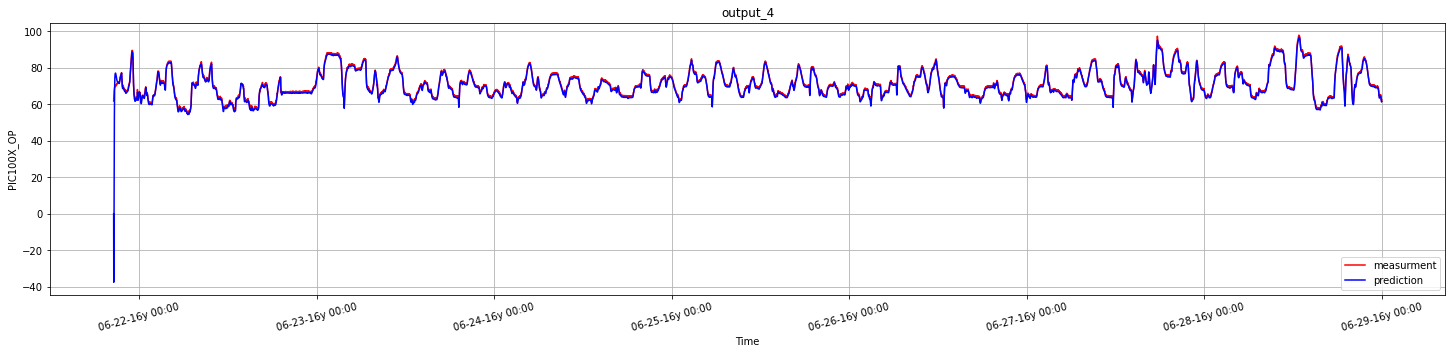

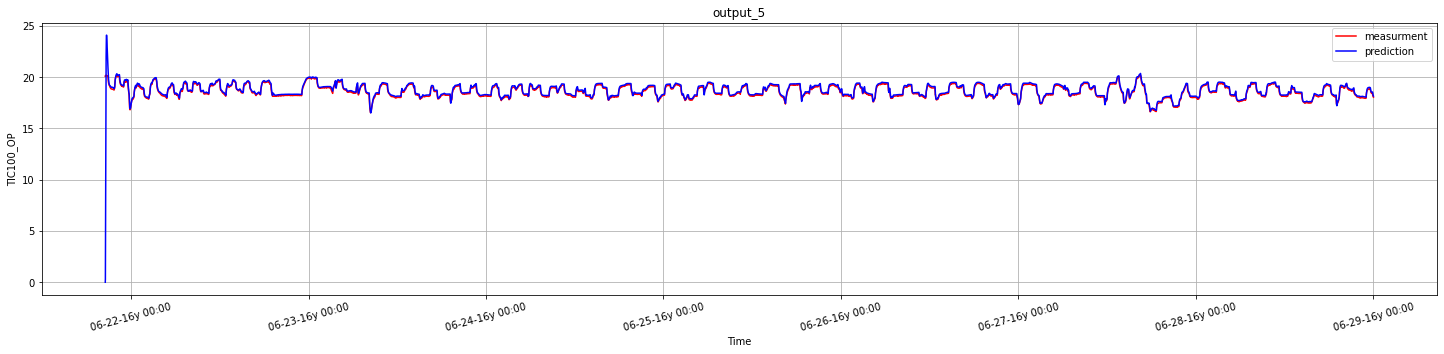

In [10]:
start_time = start
end_time = '2016-06-29 00:00:00'
plots.plot_comparison(step_test_data, model, inputs, outputs, start_time, end_time, plt_input=False, scale_plt=False)